In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, normalize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from utils import mod_df, drop_features, inverse_mod_X, inverse_mod_y, apply_savgol_filter, apply_median_filter, apply_maximum_filter, apply_is_zero
from my_model import create_model_1, create_model_1_1, create_model_1_2, create_model_1_3, create_model_2, create_model_2_1, create_model_2_2, create_model_3
tf.__version__

'2.6.0'

In [71]:
train_df = pd.read_csv(os.path.join('data', 'unionTrain.csv'))
test_df = pd.read_csv(os.path.join('data', 'unionTest.csv'))

In [72]:
X_train, y_train = mod_df(train_df)
X_test, y_test = mod_df(test_df)

In [73]:
def feature_engineering(df):
    result = df.copy()
    
    # drop features
    result = result.drop(['id', 'timestep'], axis=1)
    DEFAULT_FEATURE = result.columns.to_list()
    # result = drop_features(result, [15, 16, 17, 18, 20, 21, 23, 24])
    
    # add features
    FEATURE_COLUMNS = result.columns.to_list()
    for col in FEATURE_COLUMNS:
        feature = result[col]
        feature = feature.to_numpy()
        result[f'{col}_savgol'] = apply_savgol_filter(feature, window_size=11, polynomial=2)
        # result[f'{col}_median'] = apply_median_filter(feature)
        # result[f'{col}_max'] = apply_maximum_filter(feature)
        result[f'{col}_sav_med'] = apply_median_filter(apply_savgol_filter(feature, window_size=21), window_size=5)
        result[f'{col}_is_zero'] = apply_is_zero(feature)
    
    # modify features
    FEATURE_COLUMNS = result.columns.to_list()
    for col in FEATURE_COLUMNS:
        feature = result[col]
        feature = feature.to_numpy()
        # result[col] = apply_savgol_filter(feature)
        # result[col] = apply_median_filter(feature)
        # result[col] = apply_maximum_filter(feature)
        # result[col] = apply_median_filter(apply_savgol_filter(feature, window_size=21), window_size=5)
    
    # drop default features
    result = result.drop(DEFAULT_FEATURE, axis=1)
     
    return result

X_train_1 = feature_engineering(X_train)
X_test_1 = feature_engineering(X_test)

C:\Users\ARM\AppData\Local\Temp\ipykernel_10060\621492584.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result[f'{col}_savgol'] = apply_savgol_filter(feature, window_size=11, polynomial=2)
C:\Users\ARM\AppData\Local\Temp\ipykernel_10060\621492584.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result[f'{col}_sav_med'] = apply_median_filter(apply_savgol_filter(feature, window_size=21), window_size=5)
C:\Users\ARM\AppData\Local\Temp\ipykernel_10060\621492584.py:18: PerformanceWarning: DataFrame is highly fragmented.  T

In [74]:
# print(X_train_1['0X_savgol'][:5], X_train_1['0X'][:5])

In [75]:
# tmp = X_train_1['0X'].value_counts()
# tmp2 = np.array([tmp.index.to_numpy(), tmp.to_numpy()]).T
# tmp2[0:100, :]

In [76]:
def get_scaler(scaler_name='MinMaxScaler'):
    if scaler_name == 'RobustScaler':
        scaler = RobustScaler()
    elif scaler_name == 'MinMaxScaler':
        scaler = MinMaxScaler()
    return scaler
# scaler_name = 'RobustScaler'
scaler_name = 'MinMaxScaler'
scaler = get_scaler(scaler_name)

In [77]:
X_train_scaled = scaler.fit_transform(X_train_1)
X_test_scaled = scaler.transform(X_test_1)

X_train_scaled.shape

(91378, 150)

In [78]:
# joblib.dump(scaler, os.path.join('saved_scaler', f'{scaler_name}.pkl'))

In [79]:
X_train_modified, y_train_modified = inverse_mod_X(X_train_scaled), inverse_mod_y(y_train)
X_test_modified, y_test_modified = inverse_mod_X(X_test_scaled), inverse_mod_y(y_test)
print(X_train_modified.shape, y_train_modified.shape)

(107, 854, 150) (107, 2)


In [80]:
input_shape, n_output = (X_train_modified.shape[-2], X_train_modified.shape[-1]), y_train_modified.shape[1]
# model = create_model_1(input_shape, n_output)
# model = create_model_1_0(input_shape, n_output)
# model = create_model_1_1(input_shape, n_output)
# model = create_model_1_2(input_shape, n_output)
# model = create_model_2(input_shape, n_output)
# model = create_model_2_1(input_shape, n_output)
# model = create_model_2_2(input_shape, n_output)
model = create_model_3(input_shape,
    n_output,
    head_size=64,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    dropout=0.25,
    mlp_dropout=0.25
    )
# model = Sequential([
#         InputLayer(input_shape),
#         Bidirectional(LSTM(32, return_sequences=True)),
#         Bidirectional(LSTM(32, return_sequences=False)),
#         Dense(25, activation='selu'),
#         Dense(n_output, activation="softmax")
#     ])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 854, 150)]   0                                            
__________________________________________________________________________________________________
layer_normalization_32 (LayerNo (None, 854, 150)     300         input_4[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_16 (MultiH (None, 854, 150)     154518      layer_normalization_32[0][0]     
                                                                 layer_normalization_32[0][0]     
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 854, 150)     0           multi_head_attention_16[0][

In [81]:
optimizer = Adam(learning_rate=1e-3)
model.compile(
                optimizer=optimizer,
                loss=CategoricalCrossentropy(),
                metrics=[
                    'accuracy'
                ]
              )

In [82]:
reduce_lr = ReduceLROnPlateau(
                                monitor='val_loss',
                                factor=0.5,
                                patience=4,
                                min_lr=1e-4
                              )
early_stopping = EarlyStopping(
                                monitor='loss',
                                patience=6
                              )

In [83]:
history = model.fit(X_train_modified, y_train_modified,
          batch_size=8,
          epochs=25,
          shuffle=True,
          validation_split=0.2,
          callbacks=[
              reduce_lr,
              early_stopping,
              ]
          )

Epoch 1/25
11/11 [==============================] - 4s 139ms/step - loss: 0.7451 - accuracy: 0.5412 - val_loss: 1.0537 - val_accuracy: 0.4545
Epoch 2/25
11/11 [==============================] - 1s 100ms/step - loss: 0.6437 - accuracy: 0.6353 - val_loss: 0.5436 - val_accuracy: 0.7273
Epoch 3/25
11/11 [==============================] - 1s 98ms/step - loss: 0.5253 - accuracy: 0.7647 - val_loss: 0.4414 - val_accuracy: 0.7273
Epoch 4/25
11/11 [==============================] - 1s 101ms/step - loss: 0.5028 - accuracy: 0.7412 - val_loss: 0.6511 - val_accuracy: 0.5909
Epoch 5/25
11/11 [==============================] - 1s 100ms/step - loss: 0.4153 - accuracy: 0.7882 - val_loss: 0.3827 - val_accuracy: 0.7727
Epoch 6/25
11/11 [==============================] - 1s 101ms/step - loss: 0.3690 - accuracy: 0.8353 - val_loss: 0.5915 - val_accuracy: 0.7727
Epoch 7/25
11/11 [==============================] - 1s 97ms/step - loss: 0.2392 - accuracy: 0.9176 - val_loss: 0.5329 - val_accuracy: 0.8182
Epoch 8/

In [84]:
from datetime import datetime
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model.save(os.path.join("saved_models", f"{current_time}_{scaler_name}.h5"))

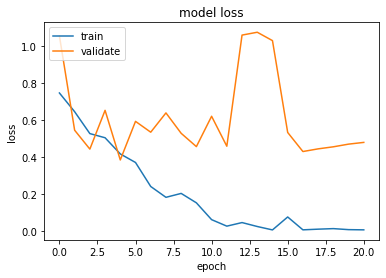

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

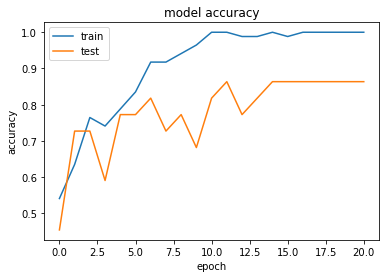

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [87]:
train_predict = model.predict(X_train_modified, batch_size=4)
train_predict = np.argmax(train_predict, axis=1)+1
train_real = np.argmax(y_train_modified, axis=1)+1

# for i in range(len(y_train_modified)):
#     print(f"Index:{i}, Predict:{train_predict[i]}, Real:{train_real[i]}")

              precision    recall  f1-score   support

           1     0.9444    1.0000    0.9714        51
           2     1.0000    0.9464    0.9725        56

    accuracy                         0.9720       107
   macro avg     0.9722    0.9732    0.9720       107
weighted avg     0.9735    0.9720    0.9720       107

---------------------------------------------------------



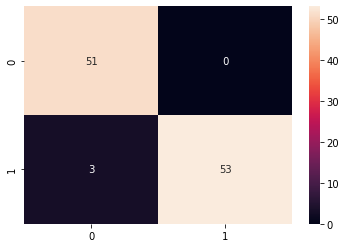

In [88]:
f1_train = f1_score(train_real, train_predict)
accuracy_train = accuracy_score(train_real, train_predict)
# print(f"f1: {f1_train:.4f}\naccuracy: {accuracy_train:.4f}")
print(classification_report(train_real, train_predict, digits=4))
print("---------------------------------------------------------")
sns.heatmap(confusion_matrix(train_real, train_predict),annot = True,fmt = '2.0f')
print()

In [89]:
test_predict_0 = model.predict(X_test_modified)
test_predict = np.argmax(test_predict_0, axis=1)+1
test_real = np.argmax(y_test_modified, axis=1)+1

# for i in range(len(y_test)):
#     print(f"Index:{i}, Predict:{test_real[i]}, Real:{test_real[i]}")

In [90]:
# for i in range(len(y_test)):
    # print(f"Index:{i}, Predict:{test_predict_0[i]}, Real:{test_real[i]}")
# plt.plot(test_predict==test_real)
# plt.plot(np.max(test_predict_0, axis=1))
# print(np.max(test_predict_0, axis=1))
# plt.plot(test_real==2)
# plt.plot(test_predict_0[:, 1]>0.35)
# for i in np.arange(0, 1, 0.05):
#     print(i, sum((test_predict_0[:, 1]>i)==(test_real==2)))
#     plt.plot((test_predict_0[:, 1]>i)==(test_real==2))
#     plt.show()

              precision    recall  f1-score   support

           1     0.3333    0.4000    0.3636         5
           2     0.7692    0.7143    0.7407        14

    accuracy                         0.6316        19
   macro avg     0.5513    0.5571    0.5522        19
weighted avg     0.6545    0.6316    0.6415        19

---------------------------------------------------------



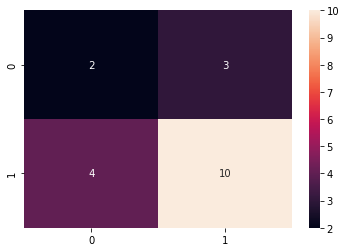

In [91]:
f1_test = f1_score(test_real, test_predict)
accuracy_test = accuracy_score(test_real, test_predict)
# print(f"f1: {f1_test:.4f}\naccuracy: {accuracy_test:.4f}")
print(classification_report(test_real, test_predict, digits=4))
print("---------------------------------------------------------")
sns.heatmap(confusion_matrix(test_real, test_predict),annot = True,fmt = '2.0f')
print()